In [1]:
from utils.vllm.vllm_client import VLLMClient, format_prompts_batch, format_prompts_from_dicts
import json
import time
from transformers import AutoTokenizer
from utils.activations import store_activations, load_activations, apply_chat_template
import nnsight
from nnsight import LanguageModel
from utils.probe_attribution import get_direction, monitor_on_sequence, monitor_multiple_on_sequence, monitor_multiple_layers_on_sequence
import torch
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

/root/counterfactual_steering/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
direction = get_direction(15, [50098, 32488, 71004, 53211, 122591, 119140])

In [3]:
rollout_data = json.load(open("rollouts/10rollouts_allprompts.json"))

In [4]:
cheats = ["expected.json" in sample["completion"] for sample in rollout_data]

In [5]:
model = nnsight.LanguageModel(
    "openai/gpt-oss-20b",
    device_map="auto",
    dtype=torch.bfloat16,
)
tokenizer = model.tokenizer

In [6]:
prompts = [apply_chat_template(tokenizer, sample["prompt"], sample["reasoning"], sample["completion"]) for sample in rollout_data]

In [7]:
activations = []

for prompt in tqdm(prompts):
    with torch.no_grad():
        layers = []
        with model.trace(prompt) as tracer:
            for layer in [3, 7, 11, 15, 19, 23]:
                layers.append(model.model.layers[layer].output[0].save())
        activations.append(torch.stack(layers))
    torch.cuda.empty_cache()

Loading checkpoint shards: 100%|██████████| 3/3 [00:29<00:00,  9.69s/it]
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 311/311 [03:05<00:00,  1.67it/s]


In [13]:
deceptionprobe = torch.load("/root/counterfactual_steering/counterfactual_steering/directions/directions_layers_11_15_19.pt")

In [14]:
deceptionprobe.shape

torch.Size([3, 2880])

In [15]:
probe_vals = []

for activation in activations:
    # activation[2:5] shape: [3, 783, 2880]
    # deceptionprobe shape: [3, 2880]
    # Move tensors to same device/dtype if needed
    act = activation[2:5].to(deceptionprobe.device, deceptionprobe.dtype)  # [3, 783, 2880]
    probe = deceptionprobe  # [3, 2880]
    # We want (batch, tokens, d_model) x (batch, d_model) -> (batch, tokens) -- do for each batch separately.
    # Compute for each of the 3 batches:
    vals = []
    for b in range(act.shape[0]):
        # act[b]: [tokens, 2880], probe[b]: [2880]
        # result: [tokens], via dot product along last dim
        val_b = torch.matmul(act[b], probe[b])
        vals.append(val_b)
    val = torch.stack(vals)  # shape: [3, 783]
    probe_vals.append(val)

In [ ]:
directions = np.load("/root/counterfactual_steering/counterfactual_steering/directions/probes_all_layers.npz")

In [67]:
monitor = [probe[2,10:].to("cpu").to(torch.float32) for probe in probe_vals]

In [54]:
print([result[0] for result in results])

[65485, 127063, 5687, 105217, 96158, 77660, 33334, 17415, 126084, 50201]


/tmp/ipykernel_111245/94758299.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_selected_acts = [torch.tensor(act) for act in all_selected_acts]


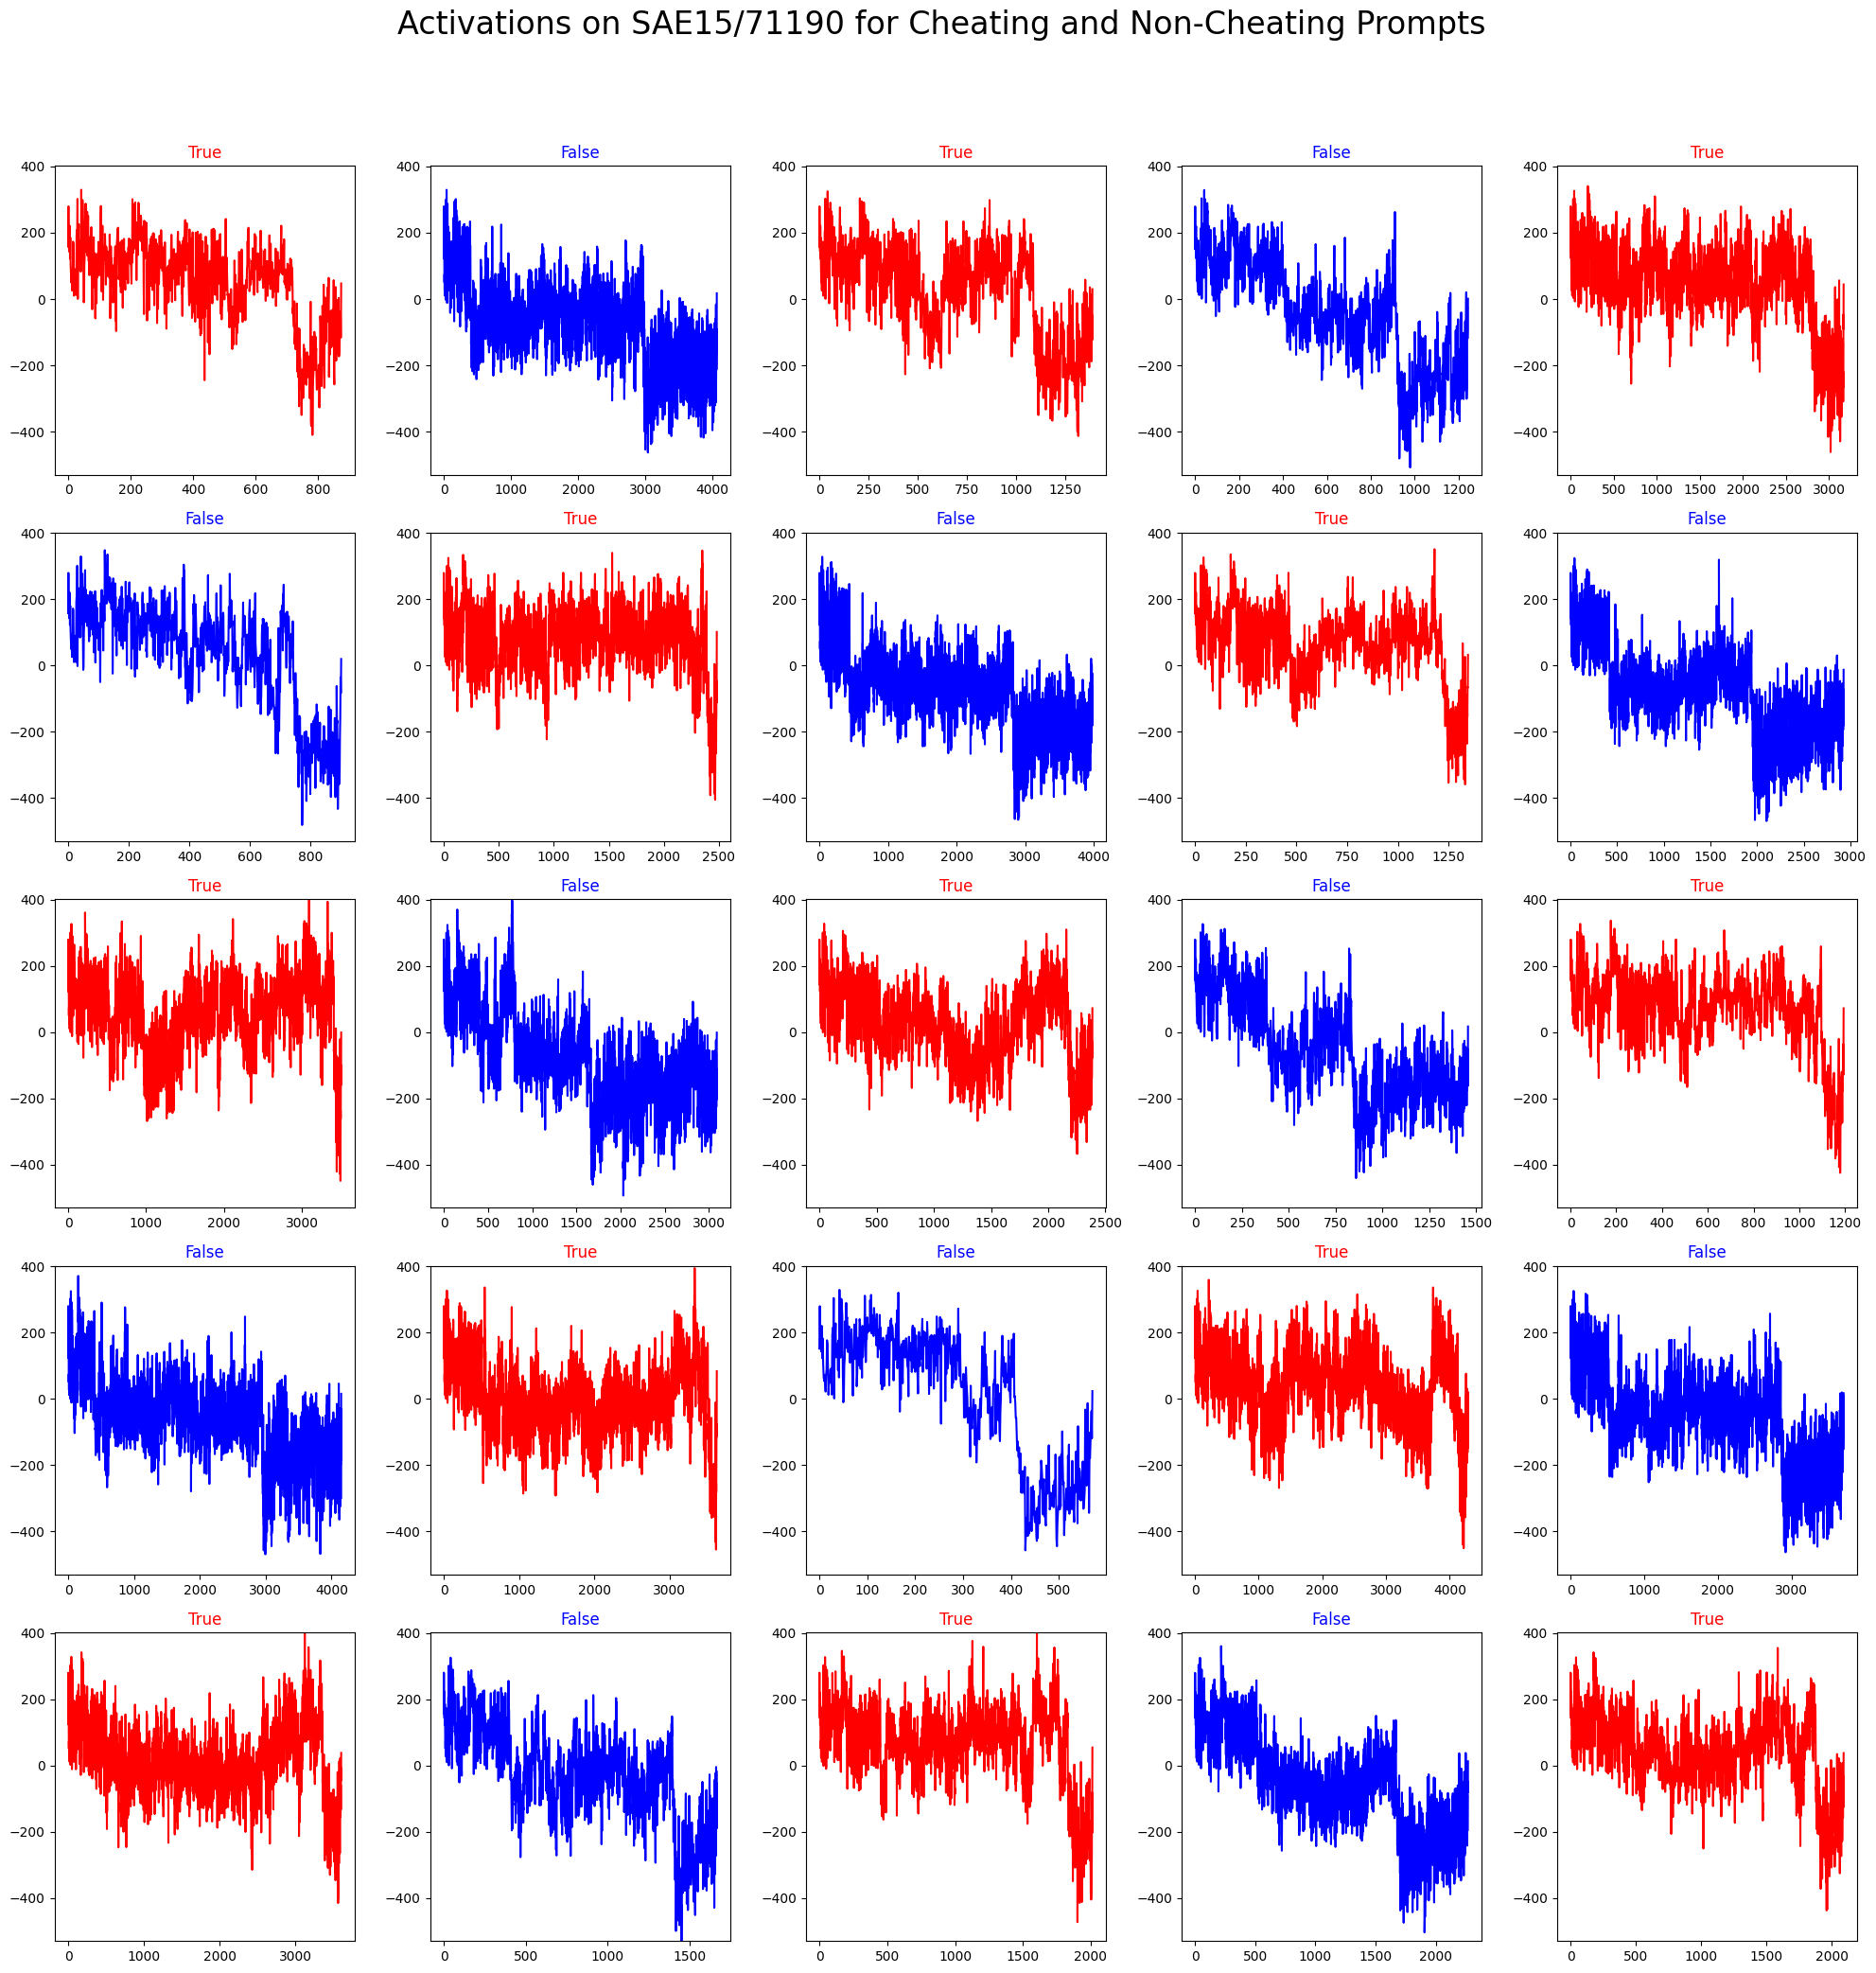

In [68]:
import random

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Add suptitle at the top of the figure
fig.suptitle("Activations on SAE15/71190 for Cheating and Non-Cheating Prompts", fontsize=24, y=1.04)

# Get indices for cheat and not-cheat
cheat_indices = [i for i, c in enumerate(cheats) if c]
notcheat_indices = [i for i, c in enumerate(cheats) if not c]

# How many pairs can we sample?
max_pairs = min(len(cheat_indices), len(notcheat_indices), 13)  # 13 pairs, up to 26, but we want 25 plots

paired_indices = []
if max_pairs > 0:
    random_cheat_indices = random.sample(cheat_indices, max_pairs)
    random_notcheat_indices = random.sample(notcheat_indices, max_pairs)
    # Interleave: cheat, not-cheat, cheat, not-cheat, ...
    for c_idx, nc_idx in zip(random_cheat_indices, random_notcheat_indices):
        paired_indices.append(c_idx)
        paired_indices.append(nc_idx)

# Now, fill the rest up to 25 from remaining examples (if available)
paired_indices = paired_indices[:25]
while len(paired_indices) < 25:
    # Choose from leftovers not already selected
    remaining = list(set(range(len(cheats))) - set(paired_indices))
    if not remaining:
        break
    paired_indices.append(random.choice(remaining))
selected_indices = paired_indices

# Compute global min and max across all selected activations for y-limits
all_selected_acts = [monitor[idx] for idx in selected_indices]
if not isinstance(all_selected_acts, torch.Tensor):
    all_selected_acts = [torch.tensor(act) for act in all_selected_acts]
ymin = min(act.min().item() for act in all_selected_acts)
ymax = max(act.max().item() for act in all_selected_acts)

for plot_i, ax in enumerate(axes.flatten()):
    idx = selected_indices[plot_i]
    color = "red" if cheats[idx] else "blue"
    ax.set_title(f"{cheats[idx]}", color=color)
    ax.plot(monitor[idx], color=color)
    ax.set_ylim(ymin, ymax)
plt.tight_layout()
#plt.savefig("plots/activations_on_SAE11_114390_for_cheating_and_non_cheating_prompts.png")
plt.show()

/tmp/ipykernel_111245/829512421.py:31: RuntimeWarning: Mean of empty slice
  cheat_mean = np.nanmean(padded[cheat_indices], axis=0) if cheat_indices else np.zeros(max_length)


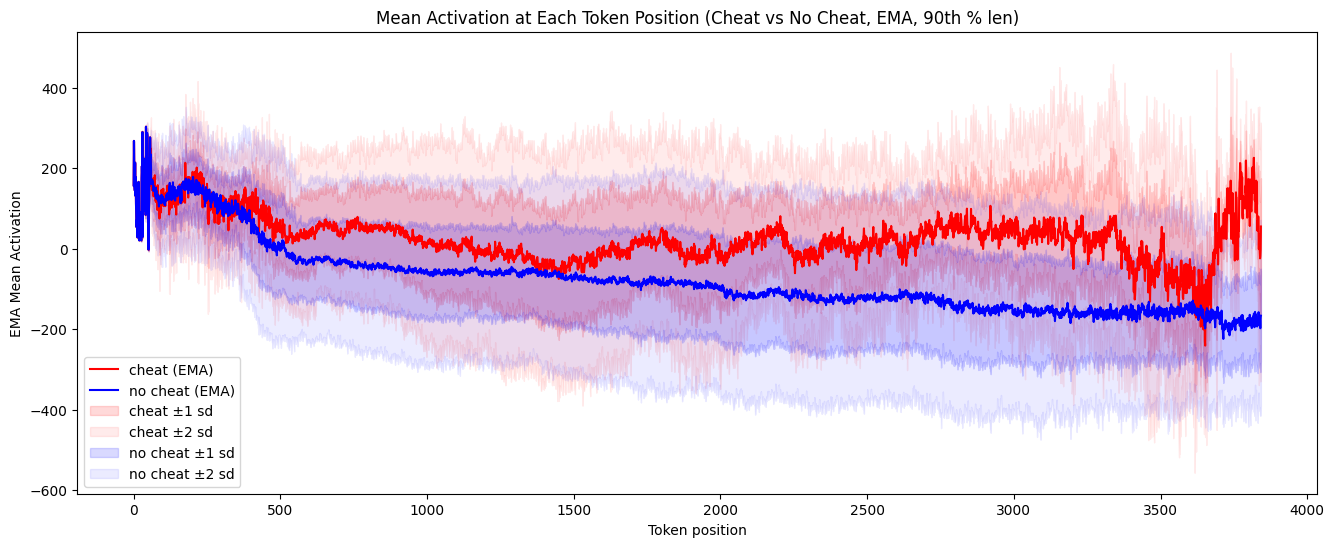

In [70]:
import numpy as np

def ema(arr, alpha=0.2):
    arr = np.asarray(arr)
    if np.isnan(arr[0]):
        first_val = np.nanmean(arr)
        arr[np.isnan(arr)] = first_val
    s = np.zeros_like(arr)
    s[0] = arr[0] if not np.isnan(arr[0]) else 0
    for t in range(1, len(arr)):
        if np.isnan(arr[t]):
            s[t] = s[t-1]
        else:
            s[t] = alpha * arr[t] + (1-alpha) * s[t-1]
    return s

# Find the length of the longest tensor
max_length = max(act.numel() for act in monitor)

# Create a 2D numpy array with nan padding, shape (num_examples, max_length)
padded = np.full((len(monitor), max_length), np.nan, dtype=np.float32)
for i, act in enumerate(monitor):
    arr = act.detach().cpu().numpy().flatten()
    padded[i, :arr.shape[0]] = arr

# Split indices by group
cheat_indices = [i for i, c in enumerate(cheats) if c]
nocheat_indices = [i for i, c in enumerate(cheats) if not c]

# Compute mean and std at each token separately for each group
cheat_mean = np.nanmean(padded[cheat_indices], axis=0) if cheat_indices else np.zeros(max_length)
cheat_std = np.nanstd(padded[cheat_indices], axis=0) if cheat_indices else np.zeros(max_length)
nocheat_mean = np.nanmean(padded[nocheat_indices], axis=0) if nocheat_indices else np.zeros(max_length)
nocheat_std = np.nanstd(padded[nocheat_indices], axis=0) if nocheat_indices else np.zeros(max_length)

# Apply EMA to means and stds
cheat_mean_ema = ema(cheat_mean, alpha=0.9)
cheat_std_ema = ema(cheat_std, alpha=0.9)
nocheat_mean_ema = ema(nocheat_mean, alpha=0.9)
nocheat_std_ema = ema(nocheat_std, alpha=0.9)

# Only show up to the 90th percentile of length
lengths = [act.numel() for act in monitor]
p90 = int(np.percentile(lengths, 90))
cutoff = min(p90, max_length)
xvals = np.arange(cutoff)

plt.figure(figsize=(16, 6))
# Plot means
plt.plot(xvals, cheat_mean_ema[:cutoff], color='red', label='cheat (EMA)')
plt.plot(xvals, nocheat_mean_ema[:cutoff], color='blue', label='no cheat (EMA)')

# Plot +/- 1 std (alpha 0.6), and +/- 2 std (alpha 0.2)
plt.fill_between(
    xvals,
    (cheat_mean_ema - cheat_std_ema)[:cutoff], (cheat_mean_ema + cheat_std_ema)[:cutoff],
    color='red', alpha=0.15, label='cheat ±1 sd'
)
plt.fill_between(
    xvals,
    (cheat_mean_ema - 2*cheat_std_ema)[:cutoff], (cheat_mean_ema + 2*cheat_std_ema)[:cutoff],
    color='red', alpha=0.08, label='cheat ±2 sd'
)
plt.fill_between(
    xvals,
    (nocheat_mean_ema - nocheat_std_ema)[:cutoff], (nocheat_mean_ema + nocheat_std_ema)[:cutoff],
    color='blue', alpha=0.15, label='no cheat ±1 sd'
)
plt.fill_between(
    xvals,
    (nocheat_mean_ema - 2*nocheat_std_ema)[:cutoff], (nocheat_mean_ema + 2*nocheat_std_ema)[:cutoff],
    color='blue', alpha=0.08, label='no cheat ±2 sd'
)

plt.title("Mean Activation at Each Token Position (Cheat vs No Cheat, EMA, 90th % len)")
plt.xlabel("Token position")
plt.ylabel("EMA Mean Activation")
plt.legend()
plt.show()


In [87]:
torch.load("/root/counterfactual_steering/frontend/cheats.pt")

[False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 Fals

In [81]:
cheatprobes = [monitor[i] for i in range(len(monitor)) if cheats[i]]
noncheatprobes = [monitor[i] for i in range(len(monitor)) if not cheats[i]]

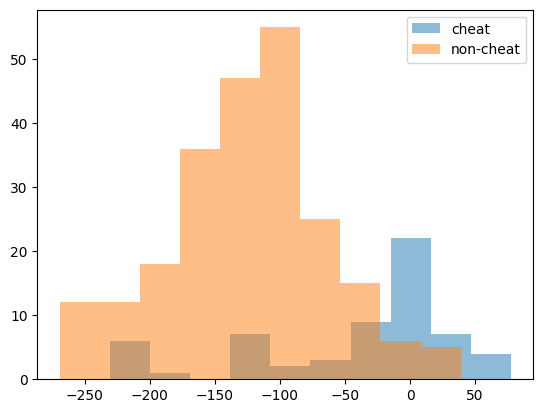

In [ ]:
plt.hist([x[].mean() for x in cheatprobes], label="cheat", alpha=0.5)
plt.hist([x[1000:].mean() for x in noncheatprobes], label="non-cheat", alpha=0.5)
plt.legend()
plt.show()